# WebRender composite counts

In [2]:
%r
library(boot)
library(dplyr, warn.conflicts=FALSE)
library(ggplot2)
library(sparklyr, warn.conflicts=FALSE)
library(tidyr, warn.conflicts=FALSE)

sc = spark_connect(method="databricks")

# Save result tables so we can access them from hala


In [3]:
from moztelemetry.dataset import Dataset
import pandas as pd
from pyspark.sql import Row
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, BooleanType, IntegerType, DoubleType, LongType, MapType
from statsmodels.stats.weightstats import DescrStatsW

EXPERIMENT_ID = "prefflip-webrender-v1-2-1492568"
EXPERIMENT_ID_2 = "prefflip-webrender-v1-3-1492568"
PARTITIONS = [s.replace("-", "_") for s in (EXPERIMENT_ID, EXPERIMENT_ID_2)]

In [4]:
  Dataset.from_source("telemetry-cohorts")

Out[ 13 ]: Dataset(bucket=u'net-mozaws-prod-us-west-2-pipeline-data', schema=[u'submissionDate', u'docType', u'experimentId', u'experimentBranch'], store=<moztelemetry.store.S3Store instance at 0x7fc575e22f80>, prefix=u'telemetry-cohorts', clauses={}, selection={}, max_concurrency=12)

In [5]:
to_summarize = {
  "composite_time": "payload.processes.gpu.histograms.COMPOSITE_TIME",
  "content_frame_time": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME",
  "content_frame_time_svg": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME_WITH_SVG",
  "content_frame_time_reason": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME_REASON",
  "content_frame_time_without_upload": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME_WITHOUT_UPLOAD",
  "content_paint_time": "payload.processes.content.histograms.CONTENT_PAINT_TIME",
  "tab_switch_composite": "payload.histograms.FX_TAB_SWITCH_COMPOSITE_E10S_MS",
  "content_full_paint_time": "payload.processes.gpu.histograms.CONTENT_FULL_PAINT_TIME",
  "page_load_ms": "payload.histograms.FX_PAGE_LOAD_MS_2"
}

to_pull = {}
for k, v in to_summarize.items():
  to_pull[k] = v + ".values"
  to_pull[k + "_sum"] = v + ".sum"

pings = (
  Dataset
  .from_source("telemetry-cohorts")
  .where(
    docType="main",
    experimentId=lambda x: x in PARTITIONS,
  )
  .select(
    app_build_id="application.buildId",
    branch='environment.experiments."%s".branch' % EXPERIMENT_ID,
    branch2='environment.experiments."%s".branch' % EXPERIMENT_ID_2,
    gfx_info='environment.system.gfx',
    gfx_description="environment.system.gfx.adapters[0].description",
    client_id="clientId",
    gfx_compositor="environment.system.gfx.features.compositor",
    normalized_channel="meta.normalizedChannel",
    profile_subsession_counter="payload.info.profileSubsessionCounter",
    session_id="payload.info.sessionId",
    target_pref_value='environment.settings.userPrefs."gfx.webrender.all.qualified"',
    # ---
    device_reset_reason_content="payload.processes.content.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_gpu="payload.processes.gpu.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_parent="payload.histograms.DEVICE_RESET_REASON.values",
    subsession_length="payload.info.subsessionLength",
    active_ticks='payload.processes.parent.scalars."browser.engagement.active_ticks"',
    total_uris='payload.processes.parent.scalars."browser.engagement.total_uri_count"',
    **to_pull
  )
  .records(sc)
)

def ping_to_row(x):
  for k, v in to_summarize.items():
    x[k + "_count"] = sum((x[k] or {}).values())
  
  x["experiment"] = (x["branch"] and 2) or 3
  x["branch"] = x["branch"] or x["branch2"]
  del x["branch2"]
  
  # Aggregate DEVICE_RESET_REASON for crash rates
  procs = ("parent", "content", "gpu")
  x["device_reset_reason_total"] = 0
  for proc in procs:
    key = "device_reset_reason_" + proc
    x[key + "_count"] = sum((x[key] or {}).values())
    x["device_reset_reason_total"] += x[key + "_count"]
    del x[key]
  
  # Calculate usage hours for crash rates
  # Based on https://github.com/mozilla/telemetry-streaming/blob/ee2eafd18a8b12a3fafca496d58789f641069bf6/src/main/scala/com/mozilla/telemetry/pings/MainPing.scala#L71-L82
  subsession_length = x["subsession_length"] or 0
  x["usage_hours"] = max(min(subsession_length/3600., 25.), 0.)
  return Row(**x)

fetching 158569.93778MB in 66160 files...

In [6]:
sdf_fields = [
  StructField("app_build_id", StringType(), True),
  StructField("branch", StringType(), False),
  StructField("client_id", StringType(), False),
  StructField("experiment", IntegerType(), False),
  StructField("gfx_compositor", StringType(), True),
  StructField("normalized_channel", StringType(), True),
  StructField("profile_subsession_counter", LongType(), True),  
  StructField("session_id", StringType(), True),
  StructField("target_pref_value", BooleanType(), True),
  StructField("device_reset_reason_parent_count", LongType(), True),
  StructField("device_reset_reason_content_count", LongType(), True),
  StructField("device_reset_reason_gpu_count", LongType(), True),
  StructField("device_reset_reason_total", LongType(), True),
  StructField("active_ticks", LongType(), True),
  StructField("total_uris", LongType(), True),
  StructField("subsession_length", LongType(), True),
  StructField("usage_hours", DoubleType(), True),
]

for k, v in to_summarize.items():
  sdf_fields.extend([
    StructField(k, MapType(StringType(), LongType()), True),
    StructField(k + "_sum", LongType(), True),
    StructField(k + "_count", LongType(), True),
  ])

sdf = spark.createDataFrame(pings.map(ping_to_row), schema=StructType(sdf_fields))

In [7]:
sdf.cache()
None

In [8]:
# Because compositor changes don't take effect until the browser restarts,
# we should discard the enrollment session we observe for each client.
# We'll find those sessions here, and then anti-join against this table later.

first_sessions = (
  sdf
  .orderBy(sdf.experiment, sdf.client_id, sdf.branch, sdf.profile_subsession_counter)
  .groupBy(sdf.experiment, sdf.client_id, sdf.branch)
  .agg(
    f.first(sdf.session_id).alias("session_id"),
  )
)

In [9]:
# Broadcast joins time-out unless the cluster is warm
spark.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

subsessions = (
  sdf
  .join(first_sessions, on=["experiment", "client_id", "branch", "session_id"], how="left_anti")
  .where(sdf.target_pref_value.isNotNull())
  .where(
    ((sdf.branch == "disabled") & (sdf.gfx_compositor == "d3d11"))
    | ((sdf.branch == "enabled") & (sdf.gfx_compositor == "webrender"))
  )
  .where(
    (sdf.normalized_channel == "beta") | (sdf.normalized_channel == "nightly")
  )
  .cache()
)

In [11]:
def make_time(p):
  if not p["composite_time"] or not p["content_frame_time"]:
    return (p['app_build_id'], p['branch'], 0.)
  composite_count = 0
  for i in p["composite_time"].values():
    composite_count += i
    
  content_frame_count = 0
  for i in p["content_frame_time"].values():
    content_frame_count += i
  
  return (p['app_build_id'], p['branch'], (1.* content_frame_count)/ composite_count)

paint_counts = subsessions.filter("app_build_id = '20181228093007'").filter("normalized_channel == 'nightly'").rdd.map(make_time)
paint_counts.cache()
sdf_fields = [
  StructField("app_build_id", StringType(), True),
  StructField("branch", StringType(), False),
  StructField("ratio", DoubleType(), True),
]
paint_counts = spark.createDataFrame(paint_counts, schema=StructType(sdf_fields))
paint_counts.createOrReplaceGlobalTempView("paint_counts")
paint_counts.count()
#def 
#pings = pings.map(lambda p: p["composite_time"])


Out[ 7 ]: 6711

In [12]:
%r
paint_counts = tbl(sc, "global_temp.paint_counts")
paint_counts %>% collect() %>% filter(branch=="enabled") %>% summary()

app_build_id branch ratio 
 Length:3556 Length:3556 Min. :0.00000 
 Class :character Class :character 1st Qu.:0.08342 
 Mode :character Mode :character Median :0.19625 
 Mean :0.24170 
 3rd Qu.:0.33714 
 Max. :1.22498

In [13]:
%r
paint_counts %>% collect() %>% filter(branch=='disabled') %>% summary()

app_build_id branch ratio 
 Length:3155 Length:3155 Min. :0.00000 
 Class :character Class :character 1st Qu.:0.07506 
 Mode :character Mode :character Median :0.19514 
 Mean :0.25724 
 3rd Qu.:0.36190 
 Max. :1.00007

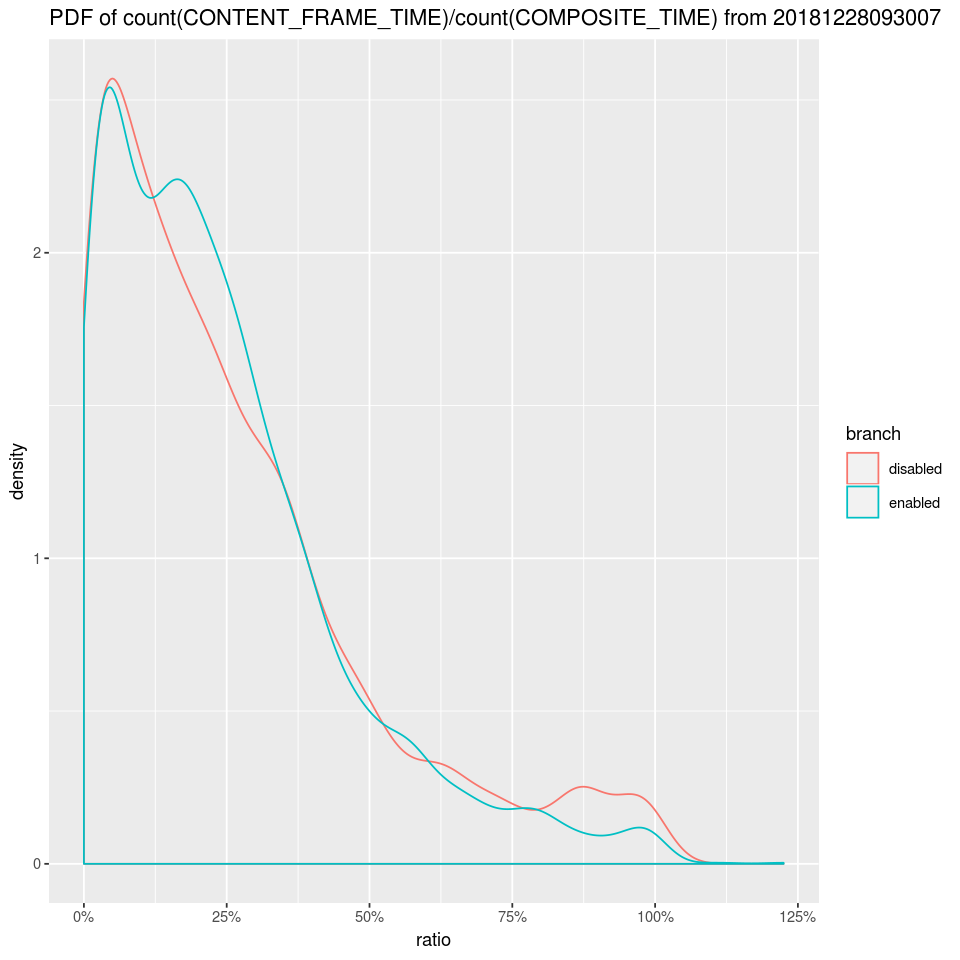

In [14]:
%r
paint_counts %>% ggplot(aes(ratio, color=branch)) + geom_density() + scale_x_continuous(labels=scales::percent) + labs(title="PDF of count(CONTENT_FRAME_TIME)/count(COMPOSITE_TIME) from 20181228093007")


In [15]:
composite_times = (subsessions.filter("app_build_id = '20181228093007'")
                   .filter("normalized_channel == 'nightly'")
                   .select('client_id','branch', 'composite_time_count', 'composite_time_sum'
                           #f.explode('composite_time').alias("bucket", "count")
                          )
                   #.groupBy('client_id', 'branch', 'bucket')
                   #.agg(f.sum("count").alias('count'))
                  )
composite_times.createOrReplaceGlobalTempView("composite_times")


In [16]:
%r
metrics = tbl(sc, "global_temp.composite_times")
per_user_build = metrics %>%
  select(branch, client_id, ends_with("_count"), ends_with("_sum")) %>%
  select(-starts_with("device_reset_reason")) %>%
  group_by(branch, client_id) %>%
  summarize_all(sum) %>%
  collect %>%
  gather("metric", "value", ends_with("_count"), ends_with("_sum")) %>%
  separate(metric, c("metric", "agg"), sep="_(?!.*_)") %>%
  spread(agg, value) %>%
  mutate(mean=sum/count)

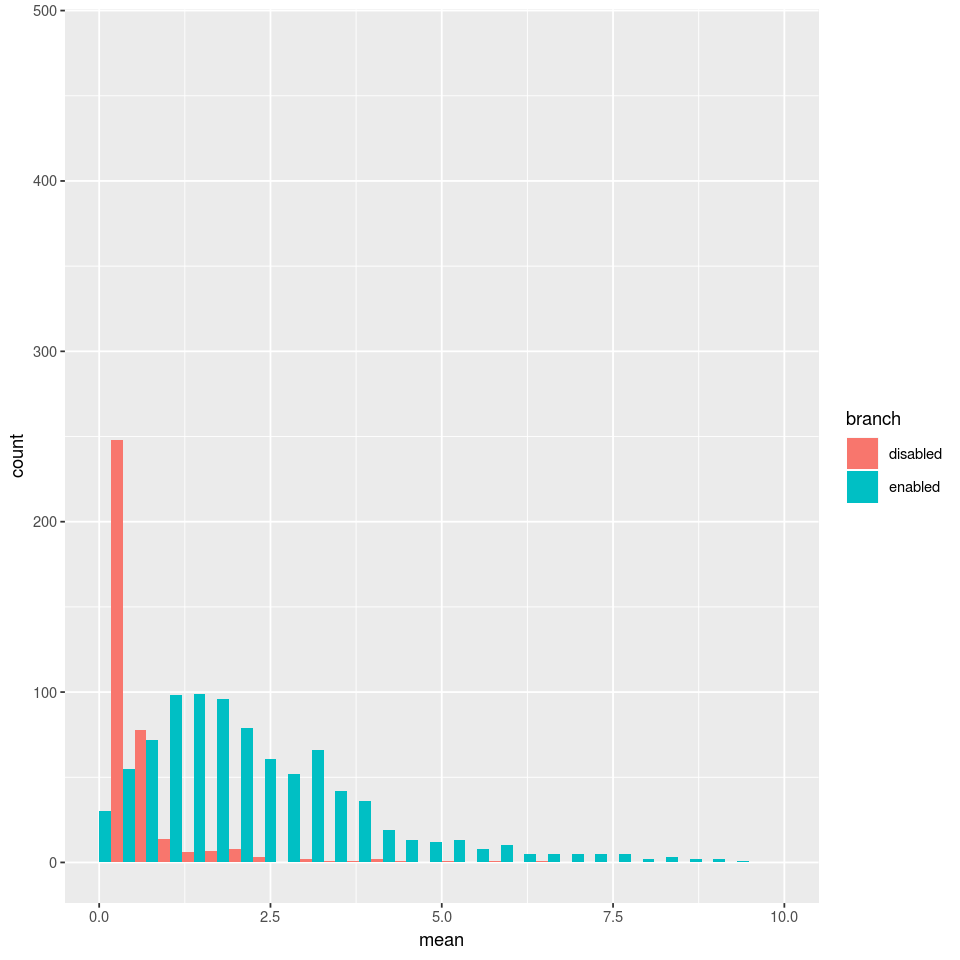

In [17]:
%r
per_user_build %>% ggplot(aes(mean, fill=branch)) + geom_histogram(position=position_dodge()) + xlim(0, 10)

In [18]:
  grouping_fields = ['client_id', 'branch', 'bucket']
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("fraction", DoubleType(), False))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def composite_udf(df):
    rows = []
    all_sum = float(df['count'].sum()) / float(df['composite_time_count'].sum())
    rows.append({"fraction": all_sum})
    data = pd.DataFrame(rows).assign(_dummy=1)
    grouping_variables = df[grouping_fields].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(data, on="_dummy").drop("_dummy", axis=1)
    return result
  

composite_times = (subsessions.filter("app_build_id = '20181228093007'")
                   .filter("normalized_channel == 'nightly'")
                   .select('client_id','branch', 'composite_time_count', 'composite_time_sum',
                           f.explode('composite_time').alias("bucket", "count")
                          )
                   .groupBy('client_id', 'branch', 'bucket')
                   .apply(composite_udf)
                  )
composite_times.createOrReplaceGlobalTempView("composite_times")
composite_times.take(3)

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-61384> in <module> () 
 2 schema = (
 3 sdf 
 ----> 4 . select ( * grouping_fields ) 
 5 . schema 
 6 . add ( StructField ( "fraction" , DoubleType ( ) , False ) ) 

 /databricks/spark/python/pyspark/sql/dataframe.pyc in select (self, *cols) 
 1336 [ Row ( name = u'Alice' , age = 12 ) , Row ( name = u'Bob' , age = 15 ) ] 
 1337 """
 -> 1338 jdf = self . _jdf . select ( self . _jcols ( * cols ) ) 
 1339 return DataFrame ( jdf , self . sql_ctx ) 
 1340 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1255 answer = self . gateway_client . send_command ( command ) 
 1256 return_value = get_return_value(
 -> 1257 answer, self.gateway_client, self.target_id, self.name)
 1258 
 1259 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.pyc in deco (*a, **kw) 
 67 e.java_exception.getStackTrace()))
 68 if s . startswith ( 'org.apache.spark.sql.AnalysisException: ' ) : 
 ---> 69 raise AnalysisException ( s . split ( ': ' , 1 ) [ 1 ] , stackTrace ) 
 70 if s . startswith ( 'org.apache.spark.sql.catalyst.analysis' ) : 
 71 raise AnalysisException ( s . split ( ': ' , 1 ) [ 1 ] , stackTrace ) 

 AnalysisException : u"cannot resolve '`bucket`' given input columns: [page_load_ms_sum, branch, device_reset_reason_gpu_count, composite_time_count, device_reset_reason_content_count, composite_time, profile_subsession_counter, content_frame_time, tab_switch_composite, content_full_paint_time_count, target_pref_value, device_reset_reason_parent_count, content_full_paint_time, client_id, content_frame_time_reason, session_id, composite_time_sum, content_full_paint_time_sum, app_build_id, content_paint_time, content_frame_time_svg, content_frame_time_svg_count, content_paint_time_count, gfx_compositor, content_frame_time_reason_sum, page_load_ms, content_frame_time_without_upload, content_paint_time_sum, normalized_channel, total_uris, device_reset_reason_total, experiment, content_frame_time_reason_count, usage_hours, subsession_length, content_frame_time_svg_sum, page_load_ms_count, content_frame_time_without_upload_count, tab_switch_composite_count, tab_switch_composite_sum, content_frame_time_count, content_frame_time_without_upload_sum, active_ticks, content_frame_time_sum];;\n'Project [client_id#108, branch#107, 'bucket]\n+- LogicalRDD [app_build_id#106, branch#107, client_id#108, experiment#109, gfx_compositor#110, normalized_channel#111, profile_subsession_counter#112L, session_id#113, target_pref_value#114, device_reset_reason_parent_count#115L, device_reset_reason_content_count#116L, device_reset_reason_gpu_count#117L, device_reset_reason_total#118L, active_ticks#119L, total_uris#120L, subsession_length#121L, usage_hours#122, content_paint_time#123, content_paint_time_sum#124L, content_paint_time_count#125L, content_frame_time#126, content_frame_time_sum#127L, content_frame_time_count#128L, content_full_paint_time#129, ... 20 more fields], false\n"

In [19]:
%r
metrics = tbl(sc, "global_temp.composite_times")
per_user_build = metrics %>%
  select(branch, client_id, ends_with("_count"), ends_with("_sum")) %>%
  select(-starts_with("device_reset_reason")) %>%
  group_by(branch, client_id) %>%
  summarize_all(sum) %>%
  collect %>%
  gather("metric", "value", ends_with("_count"), ends_with("_sum")) %>%
  separate(metric, c("metric", "agg"), sep="_(?!.*_)") %>%
  spread(agg, value) %>%
  mutate(mean=sum/count)
per_user_build

Error in mutate_impl(.data, dots) : 
 Evaluation error: non-numeric argument to binary operator.
In addition: Warning message:
Missing values are always removed in SQL.
Use `SUM(x, na.rm = TRUE)` to silence this warning

In [20]:
%r
per_user_build %>% ggplot(aes(mean, fill=branch)) + geom_histogram(position=position_dodge()) + xlim(0, 10)